# Laboratorio Universidades
Consiste en aplicar modelo de regresión lineal para predecir el porcentaje de admisión de un estudiante a una Universidad.

In [181]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

## Leyendo el dataset
Lectura del archivo. Se usará pandas

In [22]:
dataset = pd.read_csv('Admission_Predict.csv')
dataset.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [23]:
dataset.describe() # Para ver cuestiones estadísticas de las variables

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,115.614301,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,100.750000,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,200.500000,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,300.250000,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


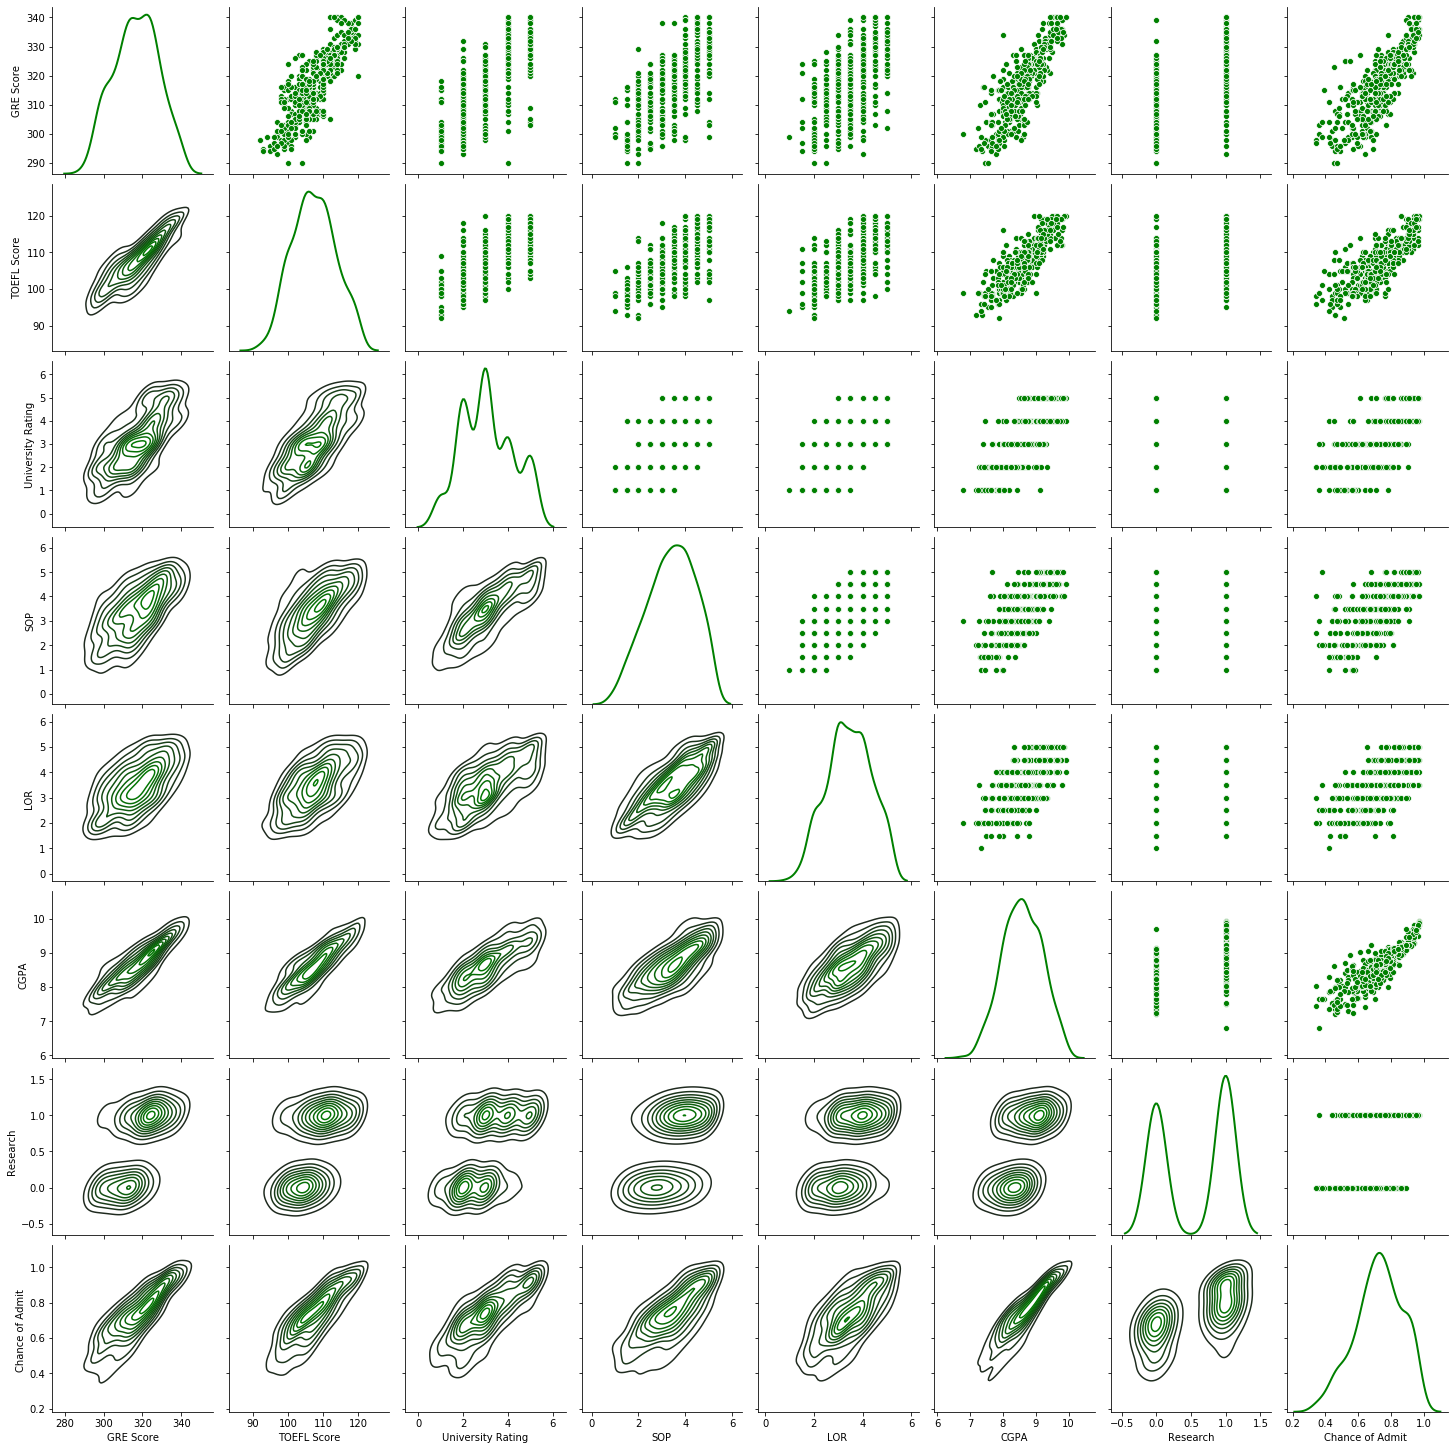

In [24]:
# Haciendo un diagrama general de todo el dataset que describa relaciones entre columnas
g = sns.PairGrid(dataset.iloc[:, 1:9], diag_sharey=False)
g.map_lower(sns.kdeplot, color='g')
g.map_upper(sns.scatterplot, color='g') # Scatter para relacionar
g.map_diag(sns.kdeplot, lw=2,color='g') # Histograma de distribución

## Tratamiento de nulos
Leyendo la cantidad de nulos en el dataset.

In [89]:
# Ver qué columnas tienen nulos y cúantos son
dataset.isna().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

## Gráfica de correlación
Indispensable para la creación de modelos lineales.

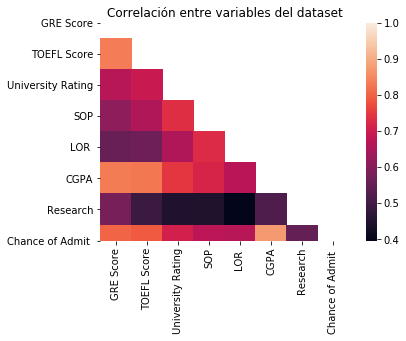

In [187]:
# Calculando la correlación entre variables (0 - 1)
corr = dataset.iloc[:, 1:9].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool)) # La máscara ayudará a que se vea en forma de escalón
# Heatmap
sns.heatmap(corr, mask=mask, square=True).set_title("Correlación entre variables del dataset");

Las variables más correlacionadas son CGPA, GRE y TOEFL

## Implementación de Regresión Lineal
Aquí se comienza la implementación de las funciones que serán de utilidad para la regresión lineal.

In [25]:
def funcion(tetas, x):
    """Realiza la regresión lineal
        multiplicación matricial de x por teta
    """
    return np.dot(x, tetas)

In [26]:
def funcion_costo(tetas, x, y, lambda_var):
    """Realiza la función de costo
        para cualquier parámetro teta
        Lambda se usa para regularizar la función
    """
    return ((np.sum(np.dot(x, tetas) - y) ** 2) + (2 * lambda_var * np.sum(np.square(tetas)))) / (2 *  len(y))

In [98]:
def derivada_teta_1(tetas, x, y, lambda_var):
    """Realiza la derivada de la función de costo
        para cualquier parámetro teta
        Lambda se usa para regularizar
    """
    return ((np.dot(x.T, np.dot(x, tetas) - y) + (lambda_var * tetas)) / len(y)) 

In [118]:
def descenso_gradiente(tetas, x, y, razon_de_aprendizaje = 0.001, numero_de_iteraciones_maximo = 10000, tolerancia = 0.1, lambda_var=0.01):
    """Sirve para implementar el descenso del gradiente
        y obtener las tetas que mejor describen la función.
    """
    # variables de flujo del gradiente
    teta_gradiente = tetas.copy()
    converger = True
    # Ciclo del descenso
    while (converger):
        # hacer derivada de funcion
        # moverse en el espacio
        numero_de_iteraciones_maximo -= 1
        teta_temporal = teta_gradiente.copy()
        derivadas = derivada_teta_1(teta_temporal, x, y, lambda_var)
        # Línea para debug
        # print("Paso: ", numero_de_iteraciones_maximo, "Costo: ", funcion_costo(teta_gradiente, x, y, lambda_var))
        # Avisar si salen Nan
        if np.isnan(derivadas).any() | np.isinf(derivadas).any():
            print("Falló en el paso", numero_de_iteraciones_maximo)
            print(teta_gradiente)
            print(derivadas)
            print("Costo: ", funcion_costo(teta_gradiente, x, y, lambda_var))
        teta_gradiente -= razon_de_aprendizaje * derivadas
        if (np.linalg.norm(derivadas) < tolerancia) or (numero_de_iteraciones_maximo == 0):
            converger = False
    return teta_gradiente

In [29]:
# Medir cuáles valores efectivamente fueron predichos
def precision_del_dataset(tetas, x, y):
    """Mide mediante aproximación si realmente predijo el 
        valor que era. 
    """
    y_pred = funcion(x, tetas)
    contador = 0
    for i in range(len(y_pred)):
        if(round(y_pred[i]) == y[i]):
            contador += 1
    return contador * 100 / len(y)

In [218]:
# Selector de modelos
def selector_de_modelos(resultados, flag_cv = False): # Selecciona el modelo con menor CV
    """Selecciona el mejor modelo de acuerdo a su testing cost.
        Puede priorizar la precisión si se activa la flag, donde
        dará prioridad al modelo con CV más bajo.
    """
    indice = 3
    if flag_cv:
        indice += 1 # Si se usa como base CV    
    comodin = resultados[0]
    for i in resultados:
        if(i[indice] < comodin[indice]):
            comodin[indice] = i[indice]
    return comodin        

#### Normalización usada para disminuir cantidades grandes
Generalmente, al tener conjuntos de datos con muchas variables la cantidad de datos es altamente probable que salgan errores como NaN o Inf, al efectuar las operaciones matriciales. Para ello, los números serán readecuados para poder efectuar con baja probabilidad la aparción de NaN e Inf. El _scaling_ sigue el siguiente modelo matemático.

\begin{align}
X_{norm} = \frac{X - X_{min}}{X_{max}-X_{min}}
\end{align}

In [278]:
# Mi implementación de CV
def cross_validation_simple(train, test, cv, degree, columnas, lambda_var, razon_de_aprendizaje = 0.01, numero_de_iteraciones_maximo=10000):
    """Es una implementación simple de CV donde se almacenan los datos 
        en arreglos distintos y luego se aplcia iterativamente con un grado
        mayor.
        1. training set
        2. testing set
        3. CV set
        4. grado hasta el que se desea iterar [x1 x1^2 x2 x2^2] para grado 2
        5. numero de columnas a utilizar del dataset inicial
    """
    partes = [train, test, cv]
    resultados = []
    for grado in range(1, degree + 1): # se le suma 1 porque Python no es inclusivo 
        resultado = []
        resultados.append([])
        for i in range(len(partes)):
            x = partes[i].iloc[:, 1:columnas].to_numpy()
            y = partes[i].iloc[:, columnas].tolist()
            # Construcción de polinomio
            x = constructor_polinomio(x, grado)
            x = np.array(x, dtype=np.float64)
            y = np.array(y, dtype=np.float64)
            tetas = [0 for i in range(((columnas - 1) * grado) + 1)] # n elementos ya que tenenmos n variables
            tetas = np.array(tetas, dtype=np.float64)
            tetas = tetas
            # Debug de formas
            #print("x ", x.shape)
            #print("y ", y.shape)
            #print("tetas ", tetas.shape)
            if (i == 0): # training
                # Escalando la data
                # Se escogió un min_max porque lo único que hace es reducir la data de tamaño
                std_scale = preprocessing.MinMaxScaler().fit(x)
                x = std_scale.transform(x)
                resultados[grado - 1].append(grado)
                resultados[grado - 1].append(std_scale)
                resultado = descenso_gradiente(tetas, x, y, razon_de_aprendizaje**grado, numero_de_iteraciones_maximo, lambda_var)
                resultados[grado - 1].append(resultado) # Guardamos tetas
            elif (i == 1): # testing
                x = std_scale.transform(x)
                resultados[grado - 1].append(funcion_costo(resultado, x, y, lambda_var))
                # resultados[grado - 1].append(precision_del_dataset(resultado, x, y)) 
            else: # CV
                x = std_scale.transform(x)
                resultados[grado - 1].append(funcion_costo(resultado, x, y, lambda_var))
                # resultados[grado - 1].append(precision_del_dataset(resultado, x, y))
                resultados[grado - 1].append(lambda_var)
    return resultados

In [177]:
# Construcción de polinomio
def constructor_polinomio(x, grado):
    """Construye columnas en un arreglo respetando el parámetro
        inicial y el grado enviado.
        1, x, x^2, x^3, x^n
    """
    x = x.T
    x_nuevo = []
    for k in x:
        for i in range(1, grado + 1): # Se le suma 1 porque Python excluye el último número
            x_nuevo.append(np.power(k, i))
    x_nuevo = np.array(x_nuevo)
    z = np.ones((len(x.T), 1))   
    x_nuevo = np.append(x_nuevo.T, z, axis=1)
    return x_nuevo

## Segmentando la data entre training, testing y CV set
Se partirá la data 80, 10, 10, para cada uno de los sets.

In [33]:
# Haciendo el splitting entre training set y test set
train, test = train_test_split(dataset, test_size=0.20) # Usé la librería de sklearn para hacerlo de manera más simple
test, cv = train_test_split(test, test_size=0.50) # Se parte entre CV y test (50 y 50 del 20%)

#### Prueba sin regularizar
Por el momento se efecutará el CV sin la regularización correspondiente. Por ello _lambda_var_ será igual a 0.

In [237]:
# El Cross-Validation se ejecutará por grados 
degree = 5 # Número de veces que se ejecuta el CV.
lambda_var = 0 # Ahorita se ejecutará sin regularizar
columnas = 8

In [279]:
modelos = cross_validation_simple(train, test, cv, degree, columnas, lambda_var)
modelos

[[1,
  MinMaxScaler(copy=True, feature_range=(0, 1)),
  array([ 0.19564148,  0.17579294, -0.11800559,  0.06407905,  0.35463343,
          0.53956627, -0.02402203,  0.        ]),
  0.06830169890257096,
  0.00596784739659599,
  0],
 [2,
  MinMaxScaler(copy=True, feature_range=(0, 1)),
  array([0.09301657, 0.08972806, 0.09312878, 0.0877639 , 0.08410091,
         0.05999886, 0.10282105, 0.07684922, 0.1099029 , 0.08203766,
         0.10441669, 0.09605812, 0.07004389, 0.07004389, 0.        ]),
  0.2448726433265061,
  0.016704854436940232,
  0],
 [3,
  MinMaxScaler(copy=True, feature_range=(0, 1)),
  array([0.00395545, 0.00384869, 0.00374189, 0.00390389, 0.00372919,
         0.00355547, 0.003862  , 0.00308705, 0.00251695, 0.00440026,
         0.00360252, 0.00296569, 0.00445666, 0.00361216, 0.00293762,
         0.00419913, 0.00393381, 0.00366971, 0.00406982, 0.00406982,
         0.00406982, 0.        ]),
  9.77157880597501,
  10.40897152580857,
  0],
 [4,
  MinMaxScaler(copy=True, feature_rang

In [239]:
# Seleccionando el modelo ganador
modelo_ganador = selector_de_modelos(modelos)
modelo_ganador

[1,
 MinMaxScaler(copy=True, feature_range=(0, 1)),
 array([ 0.19564148,  0.17579294, -0.11800559,  0.06407905,  0.35463343,
         0.53956627, -0.02402203,  0.        ]),
 0.06830169890257096,
 0.00596784739659599]

De momento el modelo ganador es el modelo lineal. Se procede a hacer la gráfica respectiva.

In [240]:
# Creando matriz de visualización para recta
res = np.zeros((columnas,columnas))
for i in range(7):
    res[i] = np.arange(0, 1, 1 / (columnas))

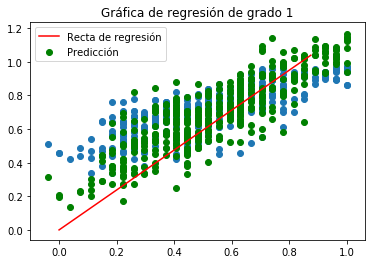

In [246]:
# Graficando nube de puntos y regresión
x = dataset.iloc[:, 1:columnas].to_numpy()
y = dataset.iloc[:, columnas].tolist()
x = constructor_polinomio(x, modelo_ganador[0])
x = np.array(x, dtype=np.float64)
x = modelo_ganador[1].transform(x)
y = np.array(y)
tetas = modelo_ganador[2]
plt.title("Gráfica de regresión de grado {}".format(modelo_ganador[0]))
plt.scatter(x.T[1], y)
plt.scatter(x.T[1], np.dot(x, tetas), color='green', label="Predicción")
plt.plot(res[1], np.dot(res.T, tetas), color='red', label ="Recta de regresión")
plt.legend()

## Prueba con regularizarización
Ahora se hará lo mismo utilizando lambda > 1.

In [209]:
# Mi implementación de CV
def cross_validation_lambda(train, test, cv, degree, columnas, lambda_var, razon_de_aprendizaje = 0.01, numero_de_iteraciones_maximo=10000):
    """Es una implementación simple de CV donde se almacenan los datos 
        en arreglos distintos y luego se aplcia iterativamente con un grado
        mayor.
        1. training set
        2. testing set
        3. CV set
        4. grado hasta el que se desea iterar [x1 x1^2 x2 x2^2] para grado 2
        5. numero de columnas a utilizar del dataset inicial
    """
    partes = [train, test, cv]
    resultados = []
    for lambdita in np.arange(lambda_var, lambda_var * 20, 0.5):
        for grado in range(1, degree + 1): # se le suma 1 porque Python no es inclusivo 
            resultado = []
            modelo = []
            for i in range(len(partes)):
                x = partes[i].iloc[:, 1:columnas].to_numpy()
                y = partes[i].iloc[:, columnas].tolist()
                # Construcción de polinomio
                x = constructor_polinomio(x, grado)
                x = np.array(x, dtype=np.float64)
                y = np.array(y, dtype=np.float64)
                tetas = [0 for i in range(((columnas - 1) * grado) + 1)] # n elementos ya que tenenmos n variables
                tetas = np.array(tetas, dtype=np.float64)
                tetas = tetas
                # Debug de formas
                #print("x ", x.shape)
                #print("y ", y.shape)
                #print("tetas ", tetas.shape)
                if (i == 0): # training
                    # Escalando la data
                    # Se escogió un min_max porque lo único que hace es reducir la data de tamaño
                    std_scale = preprocessing.MinMaxScaler().fit(x)
                    x = std_scale.transform(x)
                    modelo.append(grado)
                    modelo.append(std_scale)
                    resultado = descenso_gradiente(tetas, x, y, razon_de_aprendizaje**grado, numero_de_iteraciones_maximo, lambda_var = lambdita)
                    modelo.append(resultado) # Guardamos tetas
                elif (i == 1): # testing
                    x = std_scale.transform(x)
                    modelo.append(funcion_costo(resultado, x, y, lambdita))
                    # resultados[grado - 1].append(precision_del_dataset(resultado, x, y)) 
                else: # CV
                    x = std_scale.transform(x)
                    modelo.append(funcion_costo(resultado, x, y, lambdita))
                    # resultados[grado - 1].append(precision_del_dataset(resultado, x, y))
            modelo.append(lambdita)
            resultados.append(modelo)
    return resultados

In [190]:
# El Cross-Validation se ejecutará por grados 
degree = 5 # Número de veces que se ejecuta el CV.
lambda_var = 0.5 # Ahorita se ejecutará sin regularizar
columnas = 8

In [210]:
modelos_lambda = cross_validation_lambda(train, test, cv, degree, columnas, lambda_var)

In [211]:
# Ordenando los modelos por grado
modelos_ordenados = [[] for i in range(degree)]
for i in modelos_lambda:
    modelos_ordenados[i[0] % 5].append(i)

In [219]:
# Seleccionando el modelo ganador
modelo_ganador_lambda = selector_de_modelos(modelos_lambda, True)
modelo_ganador_lambda

[1,
 MinMaxScaler(copy=True, feature_range=(0, 1)),
 array([0.15194797, 0.15090304, 0.14327125, 0.16806617, 0.17451613,
        0.16531418, 0.13709327, 0.        ]),
 0.41894118920925993,
 0.08611662177716217,
 0.5]

In [232]:
# Creando matriz de visualización para recta
res = np.zeros((columnas,columnas))
for i in range(7):
    res[i] = np.arange(0, 1, 1 / (columnas))

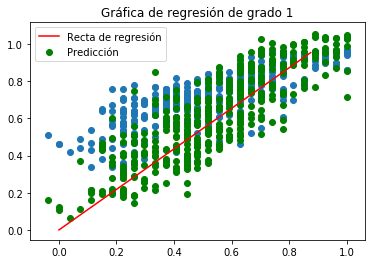

In [247]:
# Graficando nube de puntos y regresión
x = dataset.iloc[:, 1:columnas].to_numpy()
y = dataset.iloc[:, columnas].tolist()
x = constructor_polinomio(x, modelo_ganador_lambda[0])
x = np.array(x, dtype=np.float64)
x = modelo_ganador_lambda[1].transform(x)
y = np.array(y)
tetas = modelo_ganador_lambda[2]
plt.title("Gráfica de regresión de grado {}".format(modelo_ganador_lambda[0]))
plt.scatter(x.T[1], y)
plt.scatter(x.T[1], np.dot(x, tetas), color='green', label="Predicción")
plt.plot(res[1], np.dot(res.T, tetas), color='red', label ="Recta de regresión")
plt.legend()

In [336]:
# Generando un dataframe de modelos
modelos_df = pd.DataFrame(modelos_lambda)
modelos_df1 = pd.DataFrame(modelos)
modelos_df = pd.concat([modelos_df, modelos_df1])
modelos_df.columns = ["grado", "SC", "T", "Test", "CV", "L"]

In [337]:
modelos_df.head()

,grado,SC,T,Test,CV,L
0,1,"MinMaxScaler(copy=True, feature_range=(0, 1))","[0.15194796910855982, 0.15090303913130357, 0.1...",0.418941,0.086117,0.5
1,2,"MinMaxScaler(copy=True, feature_range=(0, 1))","[0.08642928839485349, 0.08368465911392489, 0.0...",0.405053,0.086117,0.5
2,3,"MinMaxScaler(copy=True, feature_range=(0, 1))","[0.0039554182083597405, 0.0038486594499040124,...",9.771591,10.408985,0.5
3,4,"MinMaxScaler(copy=True, feature_range=(0, 1))","[4.078231668104672e-05, 3.968518738960238e-05,...",10.856444,11.755434,0.5
4,5,"MinMaxScaler(copy=True, feature_range=(0, 1))","[4.0797877795716945e-07, 3.9700377892126666e-0...",10.870584,11.773240,0.5


In [340]:
modelos_df.dtypes

grado      int64
SC        object
T         object
Test     float64
CV       float64
L        float64
dtype: object

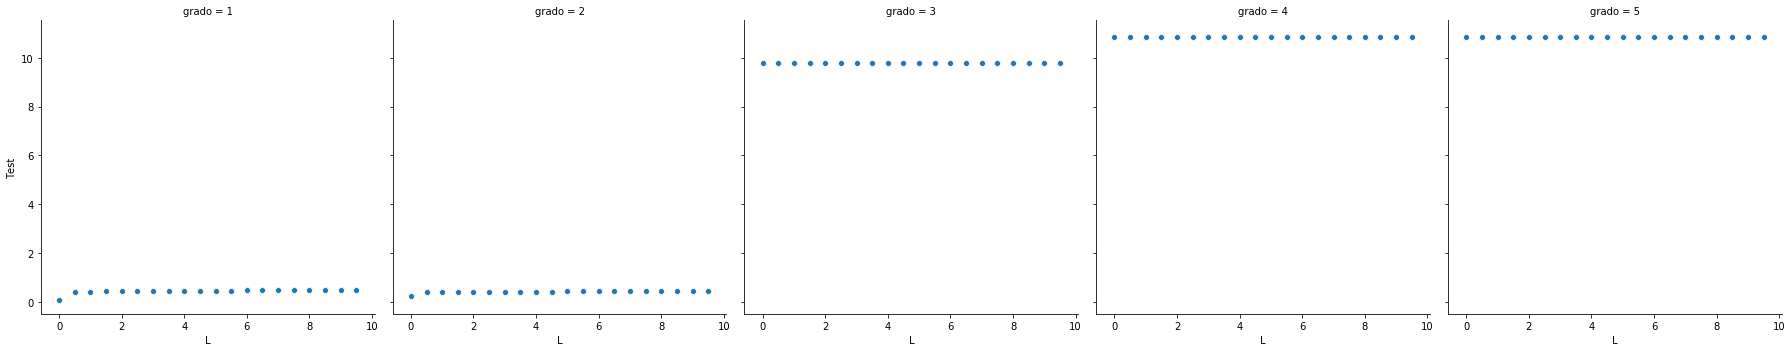

In [353]:
# Graficando Lambda para cada grado 
sns.relplot(x="L", y="Test", col="grado",
                  data=modelos_df)

#### Comentario Juandieguístico
Se percibe que los datos con grado 1 y 2 tienen costos bajos. Compararemos ambos para ver gráficamente cuál resulta mejor.

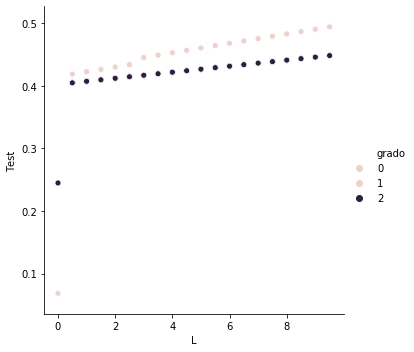

In [355]:
# Graficando Lambda para cada grado 
sns.relplot(x='L', y='Test', hue='grado',
                data=modelos_df.loc[(modelos_df['grado'] <3)])

In [358]:
modelos = modelos_lambda + modelos # Uniendo Lambda 0 y Lambda > 0
modelo_ganador = selector_de_modelos(modelos, False)
modelo_ganador

[1,
 MinMaxScaler(copy=True, feature_range=(0, 1)),
 array([0.15194797, 0.15090304, 0.14327125, 0.16806617, 0.17451613,
        0.16531418, 0.13709327, 0.        ]),
 0.06830169890257096,
 0.00596784739659599,
 0.5]

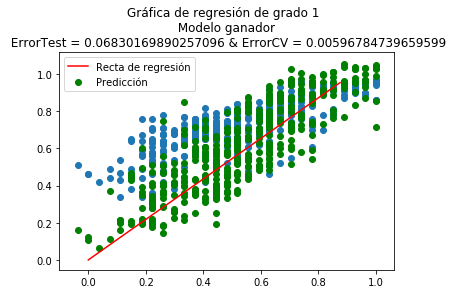

In [362]:
# Graficando nube de puntos y regresión
x = dataset.iloc[:, 1:columnas].to_numpy()
y = dataset.iloc[:, columnas].tolist()
x = constructor_polinomio(x, modelo_ganador[0])
x = np.array(x, dtype=np.float64)
x = modelo_ganador[1].transform(x)
y = np.array(y)
tetas = modelo_ganador[2]
plt.title("Gráfica de regresión de grado {}  \n Modelo ganador \n ErrorTest = {} & ErrorCV = {}".format(modelo_ganador[0], modelo_ganador[3], modelo_ganador[4]))
plt.scatter(x.T[1], y)
plt.scatter(x.T[1], np.dot(x, tetas), color='green', label="Predicción")
plt.plot(res[1], np.dot(res.T, tetas), color='red', label ="Recta de regresión")
plt.legend()

<h1>
    <center>
    <center>AMDG <p>
    <center>SDG <p>
    <center>DOG <p>
    <center>SERVIAM <p>